# Regression Module Project: Estimating Zillow Home Value

### Project Scenario:
You are a junior data scientist on the __Zillow data science team__ and recieve the following email in your inbox:

__We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.__

We have a model already, but we are hoping your insights can help us improve it. __I need recommendations on a way to make a better model.__ Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

(One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in).

-- The Zillow Data Science Team



## Import Required Libraries

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from acquire import get_zillow
from prepare import prepare_zillow

from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering, scaled_data, assessed_value_regression_plot


## Acquire prepped and split data

#### - Moving forward, train data will be used to prevent data leakage

In [2]:
train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


In [3]:
# Examine split integrity
print(f'\n\tTrain Shape: {train.shape}\n\n\tValidate Shape: {validate.shape}\n\n\tTest Shape: {test.shape}' )


	Train Shape: (29297, 8)

	Validate Shape: (12557, 8)

	Test Shape: (10464, 8)


## Initial Data Explolatory Analysis

In [4]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_date,trans_month
16035,3.0,2.0,1522.0,64360.0,1925.0,6037.0,2017-04-14,4
44800,2.0,1.0,900.0,338073.0,1951.0,6037.0,2017-08-10,8
20047,2.0,1.0,807.0,51727.0,1951.0,6037.0,2017-04-21,4
5077,3.0,3.0,2458.0,653996.0,1985.0,6059.0,2017-02-16,2
36597,3.0,2.0,1386.0,242779.0,1962.0,6037.0,2017-06-30,6


In [5]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])



In [6]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037


## Map locations with National Data

In [7]:
# Map fits with national data  
# (Source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

# Get unique locations
location = train.zip_code.unique()
location

array([6037, 6059, 6111])

### Create new columns with names of city

In [8]:
train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})

train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


In [9]:
# from uszipcode import SearchEngine, SimpleZipcode, Zipcode

# search = SearchEngine()

# def zco(x):
#     city = search.by_zipcode(x).major_city
#     return city if city else 'None'

# train['metro'] = train['zipcode'].apply(zco)

In [10]:
# Describe the data

train.describe()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
count,29297.000000,29297.000000,29297.000000,2.929700e+04,29297.000000,29297.000000,29297.000000,29297.000000
mean,3.311773,2.303137,1922.911561,5.258636e+05,5.051712,16.478479,1963.286821,6049.144861
std,0.933666,1.012818,987.408513,7.157899e+05,2.347439,8.964306,23.128629,21.030609
min,0.000000,0.000000,152.000000,9.242000e+03,1.000000,1.000000,1878.000000,6037.000000
25%,3.000000,2.000000,1270.000000,1.933730e+05,3.000000,9.000000,1950.000000,6037.000000
50%,3.000000,2.000000,1664.000000,3.724420e+05,5.000000,16.000000,1961.000000,6037.000000
75%,4.000000,3.000000,2312.000000,6.190000e+05,7.000000,24.000000,1979.000000,6059.000000
max,12.000000,11.000000,21929.000000,2.434570e+07,9.000000,31.000000,2016.000000,6111.000000


In [11]:
# Get data summary information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29297 entries, 16035 to 39200
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed_count       29297 non-null  float64
 1   bath_count      29297 non-null  float64
 2   square_feet     29297 non-null  float64
 3   assessed_value  29297 non-null  float64
 4   trans_month     29297 non-null  int64  
 5   trans_day       29297 non-null  int64  
 6   built_year      29297 non-null  int64  
 7   zip_code        29297 non-null  int64  
 8   city            29297 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 2.2+ MB


In [12]:
# Check for null values
train.isnull().sum()

bed_count         0
bath_count        0
square_feet       0
assessed_value    0
trans_month       0
trans_day         0
built_year        0
zip_code          0
city              0
dtype: int64

In [13]:
# Any null columns?
train.columns.isnull().any()

False

In [14]:
# Value counts
train.value_counts()

bed_count  bath_count  square_feet  assessed_value  trans_month  trans_day  built_year  zip_code  city       
3.0        2.0         1050.0       259334.0        5            25         1960        6037      Los Angeles    2
0.0        0.0         400.0        49627.0         5            1          1950        6037      Los Angeles    1
4.0        2.0         1576.0       82375.0         5            1          1952        6037      Los Angeles    1
                       1578.0       397610.0        5            2          1978        6111      Ventura        1
                                    96458.0         6            16         1959        6037      Los Angeles    1
                                                                                                                ..
3.0        2.0         1337.0       109332.0        6            1          1953        6037      Los Angeles    1
                       1336.0       965007.0        1            26         1946     

## Data Scalling

### Standart scaler Choosen: (Result will have a mean of 0 and a standard deviation of 1)


In [15]:
# # # Create a scaler object
# # scaler = sklearn.preprocessing.StandardScaler()

# # # Fit on train subset
# # scaler.fit(train)

#  # Transform scaler to train, validate and test subsets
# train_scaled = scaler.transform(train)
# validate_scaled = scaler.transform(validate)
# test_scaled = scaler.transform(test)

# plt.figure(figsize=(13, 6))
# plt.subplot(121)
# plt.hist(train, bins=25, ec='black')
# plt.title('Original')
# plt.subplot(122)
# plt.hist(train_scaled, bins=25, ec='black')
# plt.title('Scaled')

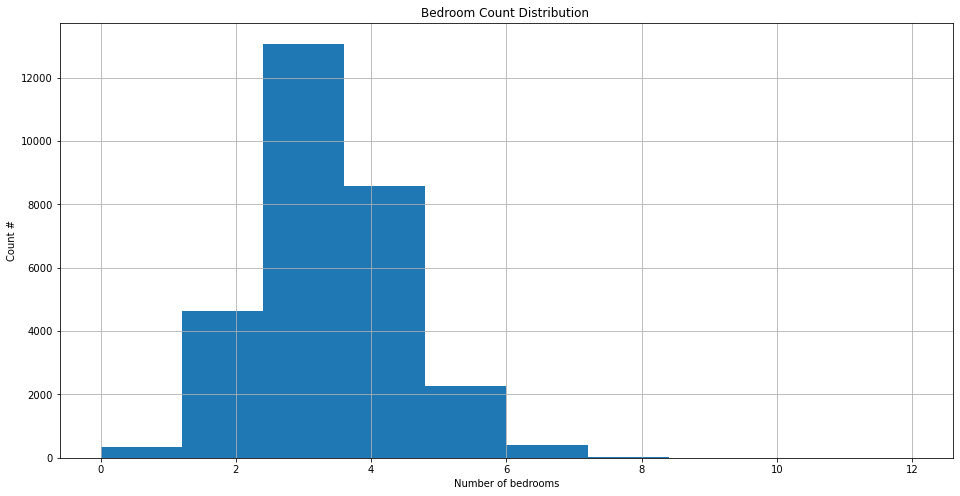

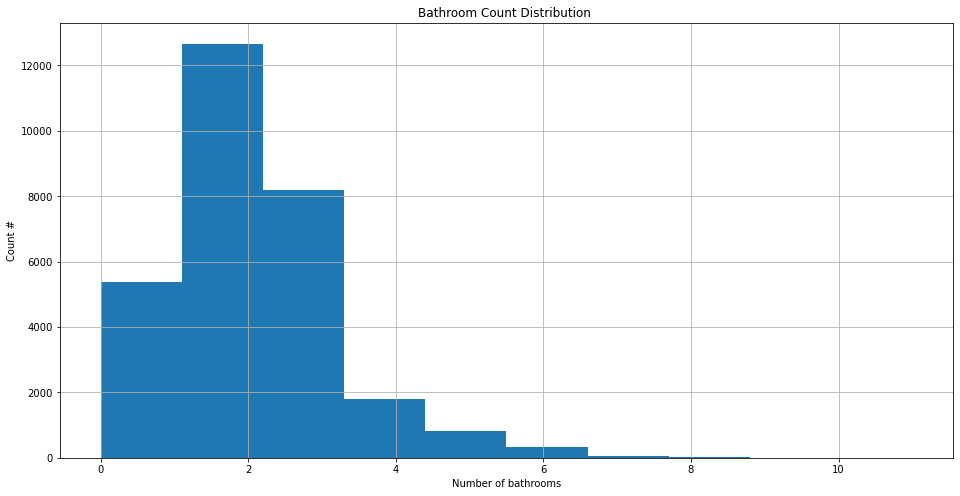

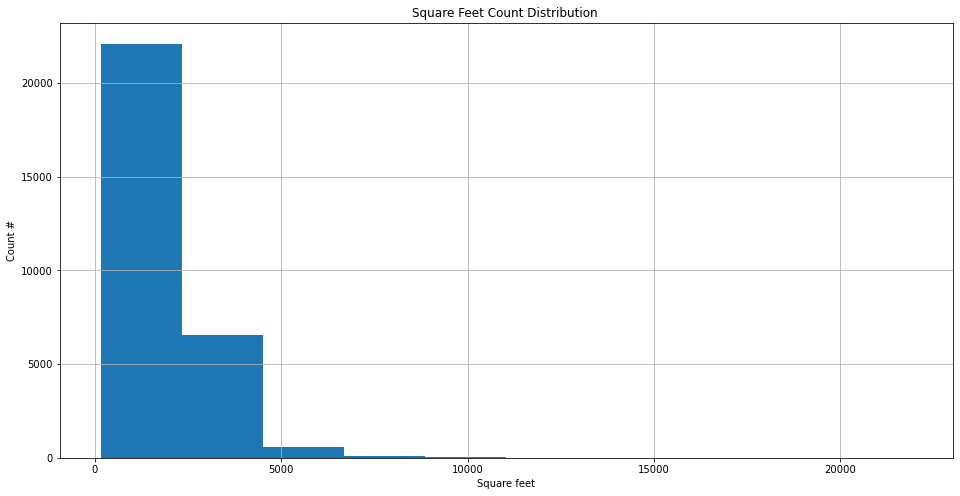

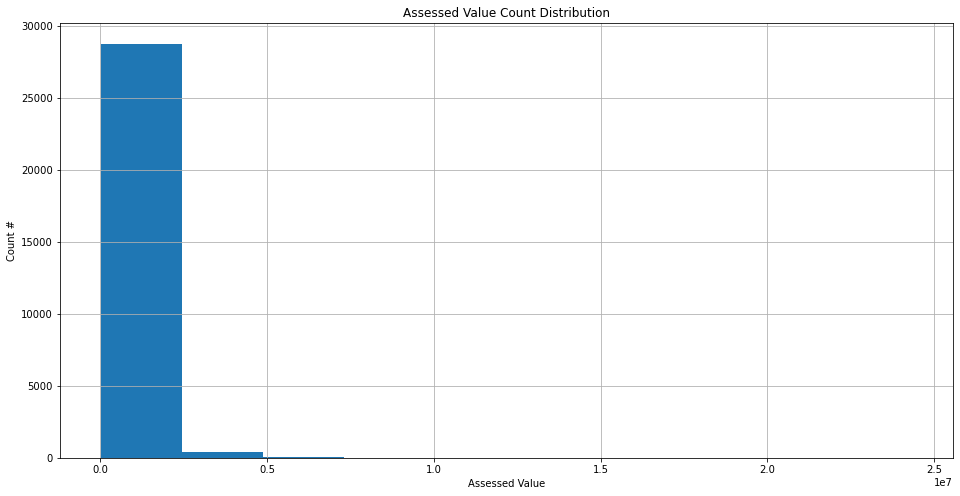

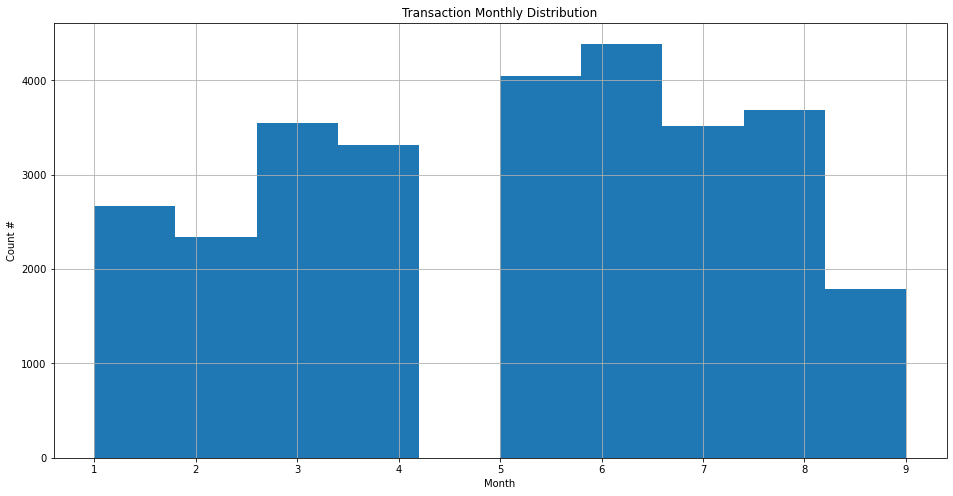

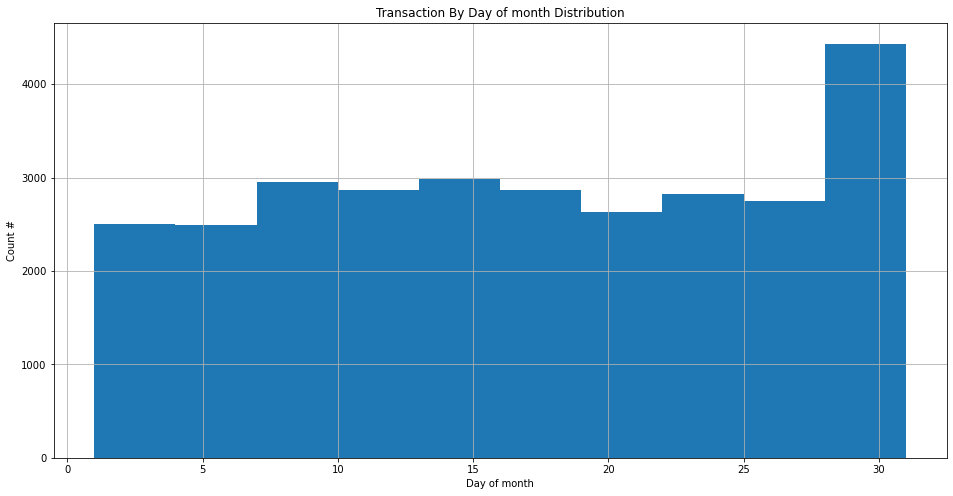

In [16]:
# Initial Visualizations
plt.figure(figsize = (16, 8))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Square Feet Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Assessed Value Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Assessed Value')
train.assessed_value.hist()
plt.show()

plt.figure(figsize = (16, 8))
plt.title('Transaction Monthly Distribution')
plt.ylabel('Count #')
plt.xlabel('Month')
train.trans_month.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Transaction By Day of month Distribution')
plt.ylabel('Count #')
plt.xlabel('Day of month')
train.trans_day.hist()
plt.show()

In [17]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


## Key Findings:
### __NOTE:_ All homes in dataset are zillow homes of 2017
- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s.
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s.
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Most transactions were average throughout the year but peaked towards the last few days of teh year. 


## Initial possible drivers for home value:

- Homes with __square feet greater than 2000__ are more likely to be bougth and sold than those below that value
- Homes with bedroom count between __3 and 4__ are more likely to generate more assessed value than other homes.
- The more the __batrooms (over 3) a home has__, the likely the rise in assessed value. 
- Homes __built after the year 2000__ are more likely to have higher assessed home value than those built before that year.
- Homes in __Los Angels__ are likely to be highly assessed due to size of city than those in Orange and Ventura


# Exploration Phase:

## Hypothesis Formulation & Testing

# Hypothesis I:  
## Q: Is there a correlation between homes square feet and its assessed value?


##### H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
##### H1 = 'Homes square feet is correlated to its variation in assessed value.'

> ### Visualize Square Feet VS Assessed Value

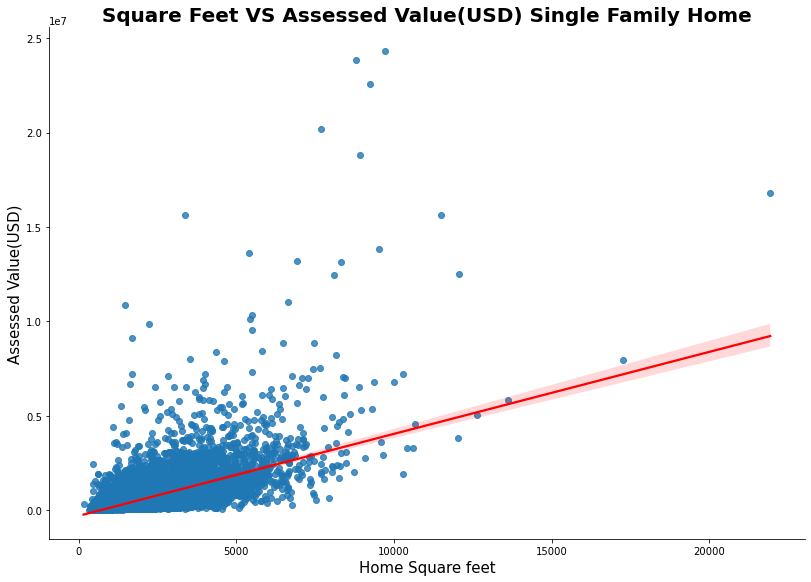

In [93]:
# Create lmplot showing regression
sns.lmplot(x = "square_feet", y = "assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws = {'color': 'red'})

plt.title('Square Feet VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Square feet', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

### Create Zillow Correlation 

In [101]:
zillow_corr = train.drop(columns = ['city','trans_day', 'zip_code','built_year']).corr()
zillow_corr

,bed_count,bath_count,square_feet,assessed_value,trans_month
bed_count,1.000000,0.646463,0.629773,0.273847,0.009464
bath_count,0.646463,1.000000,0.848716,0.507330,0.015495
square_feet,0.629773,0.848716,1.000000,0.599351,0.007299
assessed_value,0.273847,0.507330,0.599351,1.000000,0.009645
trans_month,0.009464,0.015495,0.007299,0.009645,1.000000


### Create Correlation Heatmap 

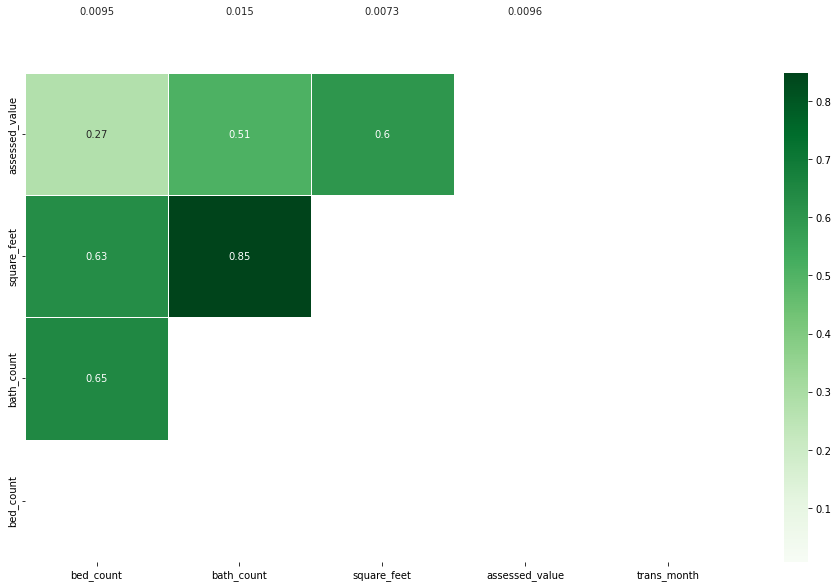

In [112]:
plt.figure(figsize=(16,9))
sns.heatmap(zillow_corr, cmap='Greens', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.ylim(0, 4)

plt.show()

### Calculate Correlation Coefficient (pearsonr)

In [118]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.square_feet, train.assessed_value)

print(f'\n\tCorrelation Coefficient: {r}\n\n\tP-value: {p_value}\n')



	Correlation Coefficient: 0.5993514769224604

	P-value: 0.0



In [ ]:
### With Spearman 

In [117]:
# Since my variables are not normally distributed, I might choose Spearman instead.

zillow_spearman = train.drop(columns=['city','trans_day', 'zip_code','built_year']).corr(method='spearman')
zillow_spearman


,bed_count,bath_count,square_feet,assessed_value,trans_month
bed_count,1.000000,0.639101,0.667909,0.296526,0.010176
bath_count,0.639101,1.000000,0.839867,0.489350,0.018618
square_feet,0.667909,0.839867,1.000000,0.529989,0.015074
assessed_value,0.296526,0.489350,0.529989,1.000000,0.018006
trans_month,0.010176,0.018618,0.015074,0.018006,1.000000


>## Test hypothesis I

In [ ]:
# Formulated hypothesis
H0 = 'There is no correlation between the homes square feet and and its variation in assessed value.'
H1 = 'Homes square feet is correlated to its variation in assessed value.'

# Hypothesis II:  
## Q: Is there a correlation between home's number of bedrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bedroom and and its variation in assessed value.'
##### H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

> ### Visualize Number of Bedrooms VS Assessed Value

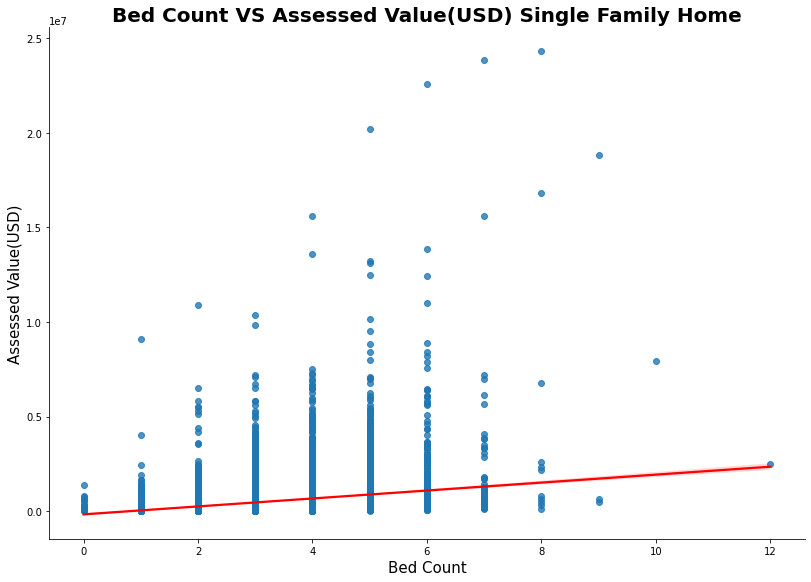

In [76]:
# Create lmplot showing regression
sns.lmplot(x="bed_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bed Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

>## Test hypothesis II

In [ ]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bedrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bedroom is correlated to its variation in assessed value.'

# Hypothesis III:  
## Q: Is there a correlation between home's number of bathrooms and its assessed value?

##### H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
##### H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

> ### Visualize Number of Bedrooms VS Assessed Value

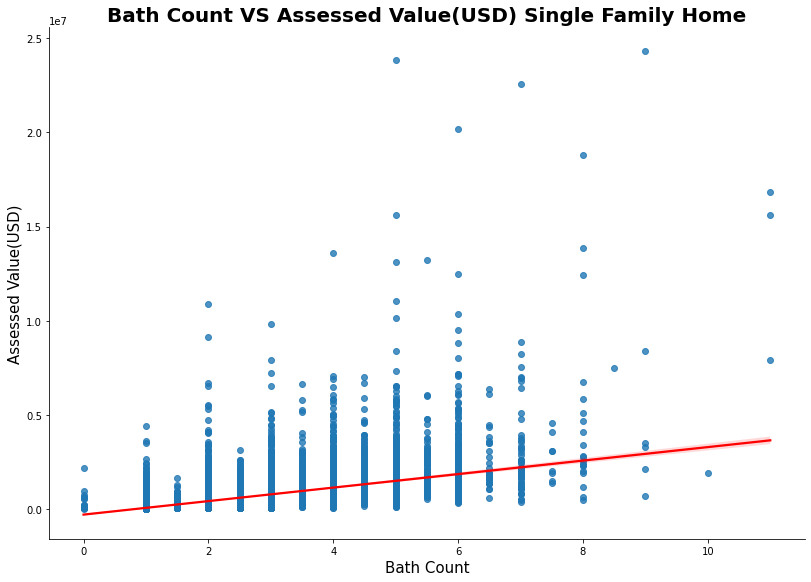

In [80]:
# Create lmplot showing regression
sns.lmplot(x="bath_count", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Bath Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Bath Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

>## Test hypothesis III

In [ ]:
# Formulated hypothesis
H0 = 'There is no correlation between the home\'s number of bathrooms and and its variation in assessed value.'
H1 = 'Home\'s number of bathrooms is correlated to its variation in assessed value.'

# Hypothesis IV:  
## Q: Is there a correlation between transaction month and its assessed value?

##### H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
##### H1 = 'Transaction month is correlated to its variation in assessed value.'

> ### Visualize Transaction Month VS Assessed Value

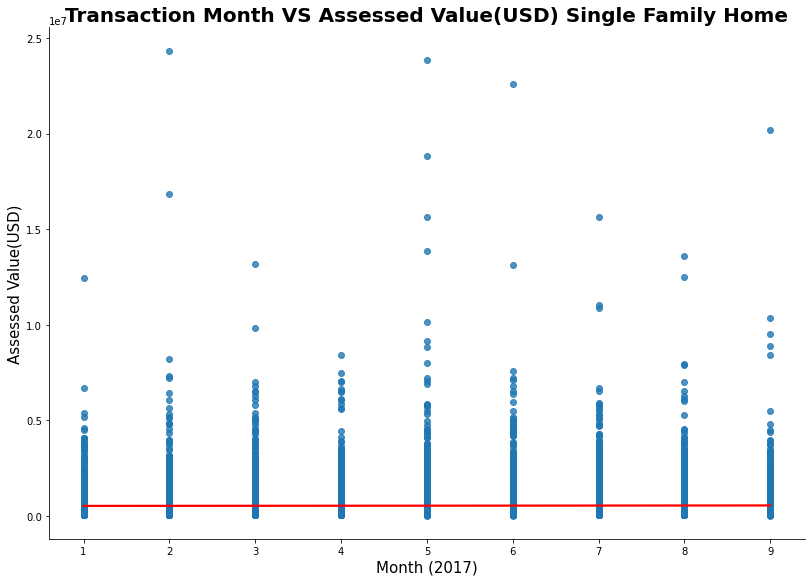

In [81]:
# Create lmplot showing regression
sns.lmplot(x="trans_month", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Transaction Month VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Month (2017)', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

>## Test hypothesis IV

In [ ]:
# Formulated hypothesis
H0 = 'There is no correlation between transaction month and and its variation in assessed value.'
H1 = 'Transaction month is correlated to its variation in assessed value.'

# Hypothesis V:  
## Q: Is there a correlation between a home\'s location and its assessed value?

##### H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
##### H1 = 'A home\s location is correlated to its variation in assessed value.'

> ### Visualize Transaction Month VS Assessed Value

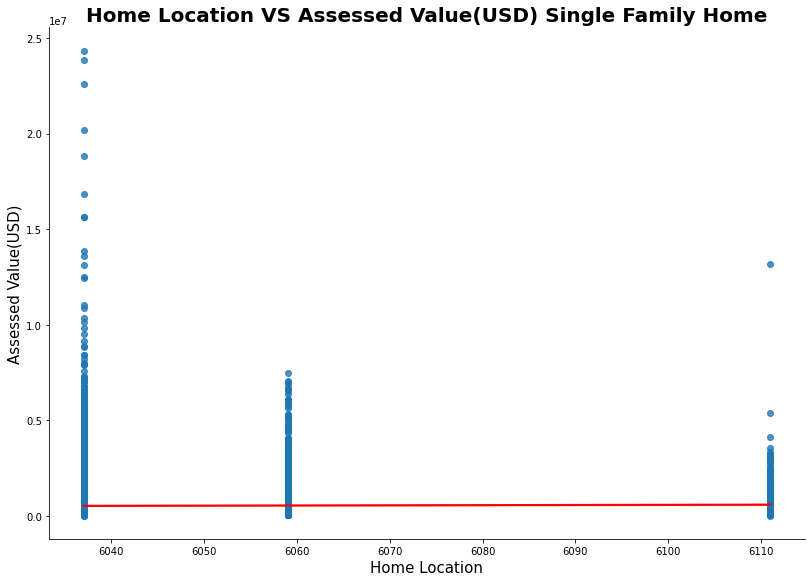

In [85]:
# Create lmplot showing regression
sns.lmplot(x="zip_code", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Home Location VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Home Location', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

>## Test hypothesis V

In [89]:
# Formulated hypothesis
H0 = 'There is no correlation between a home\'s location and and its variation in assessed value.'
H1 = 'A home\'s location is correlated to its variation in assessed value.'

# Feature Engineering (SelectKBest, RFE)

>#### Finding features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [30]:
train.columns

Index(['bed_count', 'bath_count', 'square_feet', 'assessed_value',
       'trans_month', 'trans_day', 'built_year', 'zip_code', 'city'],
      dtype='object')

In [31]:
# Select features to explore 

X_train = train[['bed_count', 'bath_count', 'square_feet',
                 'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet', 
                       'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet', 
               'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_test = test.assessed_value

## SelectKBest

In [32]:
select_k_best = select_kbest_feature_engineering(X_train, y_train, 3)
select_k_best

Enter count of SelectKBest features to return: 3


Index(['bed_count', 'bath_count', 'square_feet'], dtype='object')

>### Rank SelectKBest Features

In [33]:
kbest = SelectKBest(f_regression, k = 2)

kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fbbadb60e50>)

In [34]:
kbest_results = pd.DataFrame(dict(p = kbest.pvalues_, 
                                  f = kbest.scores_), 
                             index = X_train.columns)
kbest_results

,p,f
bed_count,0.000000e+00,2375.005194
bath_count,0.000000e+00,10153.362041
square_feet,0.000000e+00,16422.875486
trans_month,9.875797e-02,2.725661
trans_day,6.599920e-04,11.601159
built_year,2.183660e-208,964.559699
zip_code,3.179239e-05,17.312943


In [35]:

X_train_transformed = pd.DataFrame(kbest.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[kbest.get_support()])


X_train_transformed.head()


,bath_count,square_feet
16035,2.0,1522.0
44800,1.0,900.0
20047,1.0,807.0
5077,3.0,2458.0
36597,2.0,1386.0


## Recursive Feature Elimination (RFE)

In [37]:
rfe_feature_engineering(X_train, y_train, 3)

Enter count of RFE features to return: 3


Index(['bed_count', 'bath_count', 'built_year'], dtype='object')

>### Rank RFE Features

In [ ]:
# Call linear reg'
model = LinearRegression()

# Fit the model and select best two features (n_features_to_select = 2)
rfe = RFE(model, n_features_to_select = 2)
rfe.fit(X_train, y_train)

# Rank the RFE features
pd.DataFrame({'rfe_ranks': rfe.ranking_}, index = X_train.columns)

In [ ]:
# RFE Ranking
X_train_transformed = pd.DataFrame(rfe.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[rfe.support_])

X_train_transformed.head()

# <u>Best 3 Feature for Predicting Assessed Value</u>

## (A). SelectKBest Feature Results:

### ['bed_count', 'bath_count', 'square_feet']

#### Overall Ranking
#### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day','built_year', 'zip_code'],

## (B). RFE Feature Results:
### ['bed_count', 'bath_count', 'built_year']

#### Overall Ranking
### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day', 'built_year', 'zip_code']


## Moving forward... 
### Features of interest: 
>- #### Bed Count
>- #### Bath Count
>- #### Square Feet
>- #### Transaction Month
>- #### 

### If time permits:
>- #### Location

__NOTE:__ Bed and bathroom count equally had same ranking on assessed value

#  Exploration Visualizations

> ### Bed Count VS Assessed Value

> ### Bath Count VS Assessed Value

> ### Transaction Month VS Assessed Value

> ### Build Year VS Assessed Value

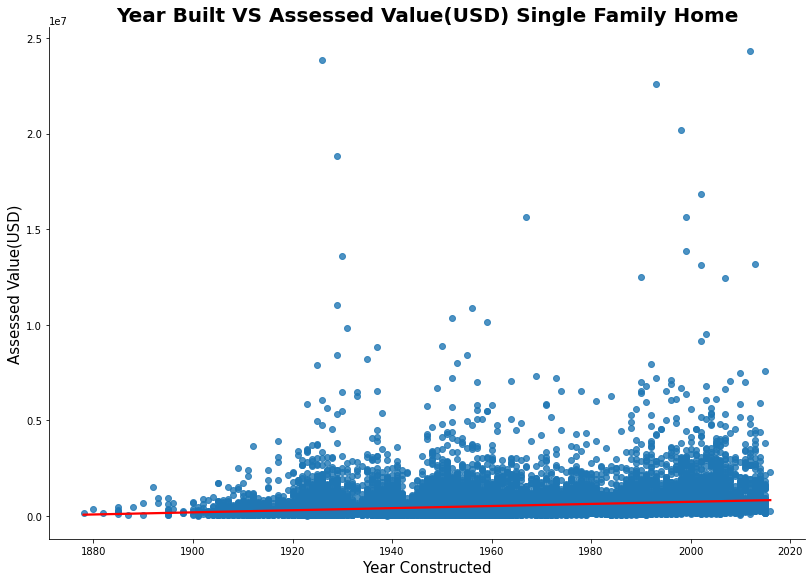

In [43]:
# Create lmplot showing regression
sns.lmplot(x="built_year", y="assessed_value", data = train, 
            height = 8, aspect = 11.7/8.27, line_kws={'color': 'red'})

plt.title('Year Built VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'bold', size = 20)
plt.xlabel('Year Constructed', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

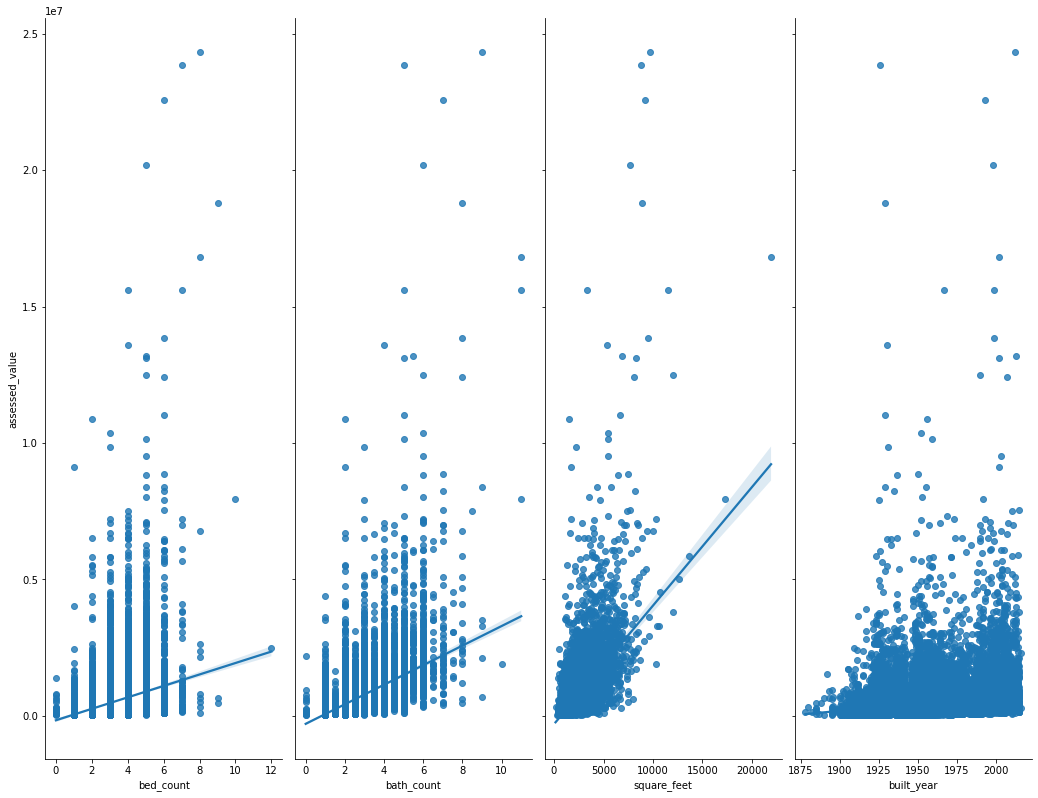

In [60]:
g = sns.pairplot(train, kind='reg', x_vars = ['bed_count', 'bath_count', 'square_feet', 'built_year'], 
                 y_vars = ['assessed_value'])
g.fig.set_size_inches(15,15)

## Create a copy of train, validate and test dataframe for scalling***

In [ ]:
train_to_scale = train.copy()
validate_to_scale = validate.copy()
test_to_scale = test.copy()

train_to_scale = train_to_scale.drop(columns = 'city')
validate_to_scale = validate_to_scale.drop(columns = 'city')
test_to_scale = test_to_scale.drop(columns = 'city')

> ### Bed Count VS Assessed Value (Scaled Data)*****

In [57]:
# # Create Scaled dataframes
# train_scaled, validate_scaled, test_scaled = scaled_data(train_to_scale, validate_to_scale, test_to_scale)
# # Reshape array & rename cols 
# bed_features_scaled = pd.DataFrame(np.array(train_scaled[['bed_count', 'assessed_value']].to_numpy()), columns = ['bed_count', 'assessed_value'])
# bed_features_scaled.head(3)

In [58]:
# # Map X, and y to features of interest and check lenght

# X = bed_features_scaled['bed_count']
# y = bed_features_scaled['assessed_value']

# plt.figure(figsize = (16, 10))
# plt.scatter(X, y)
# plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
# plt.xlabel('Bed Count', size = 15, color = 'black')
# plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
# plt.show()

## Exploration Testing

In [ ]:
### Is there a relationship between 

# Modeling Phase: 

## Feature Engineering

## Establish Baseline

## Build Models

## Model Evaluations

## Model Selection & Testing

# Conclusions and Delivery: 